# IBM Applied Data Science Capstone

This will be mainly used for the capstone project.

## Introduction

A description of the problem and a discussion of the background

Suppose you are driving in a terrible weather condition. On the way, you come across a car accident on the other side of the highway, they must be in critical condition for all of this to be happening since police cars start appearing and there's a helicopter transporting the ones involved in the crash. You don't want those horrible things to happen to you so if there's a way that can warn you ahead then you would drive more carefully or even change your driving plan if you're able to. So the problem becomes: given the weather, the road conditions and other features about the possibility of you getting into an accident, to predict the severity of an accident.

## Dataset

A description of the data and how it will be used to solve the problem

I will use collisions of Seattle(shared data) for this problem, it includes all types of collisions. Timeframe: 2004 to Present. In total, there are 37 attributes (columns) in this dataset, some have missing data. The first column **SEVERITYCODE** is the labeled data, which describes the fatality of an accident. The remaining columns have different types of attributes, such as **ADDRTYPE** stands for Collision address type of Alley, Blok, or intersection; **PERSONCOUNT** means the total number of people involved in the collision, etc, which can be used to train the model. Since it has unbalanced labels, should balance the data first to avoid a biased ML model.

In [2]:
import pandas as pd
import numpy as np
import pylab as pl
import scipy.optimize as opt
%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
print ('Hello Capstone Project Course!')

Hello Capstone Project Course!


## Data Snapshot

In [3]:
df = pd.read_csv('https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv')
df.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [4]:
df.shape

(194673, 38)

In [5]:
df.isna().sum()

SEVERITYCODE           0
X                   5334
Y                   5334
OBJECTID               0
INCKEY                 0
COLDETKEY              0
REPORTNO               0
STATUS                 0
ADDRTYPE            1926
INTKEY            129603
LOCATION            2677
EXCEPTRSNCODE     109862
EXCEPTRSNDESC     189035
SEVERITYCODE.1         0
SEVERITYDESC           0
COLLISIONTYPE       4904
PERSONCOUNT            0
PEDCOUNT               0
PEDCYLCOUNT            0
VEHCOUNT               0
INCDATE                0
INCDTTM                0
JUNCTIONTYPE        6329
SDOT_COLCODE           0
SDOT_COLDESC           0
INATTENTIONIND    164868
UNDERINFL           4884
WEATHER             5081
ROADCOND            5012
LIGHTCOND           5170
PEDROWNOTGRNT     190006
SDOTCOLNUM         79737
SPEEDING          185340
ST_COLCODE            18
ST_COLDESC          4904
SEGLANEKEY             0
CROSSWALKKEY           0
HITPARKEDCAR           0
dtype: int64

## Feature Selection

Training features:
* **WEATHER**: A description of the weather conditions during the time of the collision.  
* **LIGHTCOND**: light condition - The light conditions during the collision. 
* **ROADCOND**: road condition - The condition of the road during the collision. 
* **JUNCTIONTYPE**: Category of junction at which collision took place. 
* **PERSONCOUNT**: The total number of people involved in the collision. 
* **VEHCOUNT**: vehicle count - The number of vehicles involved in the collision. <br><br>

Label data: 
* **SEVERITYCODE**: A code that corresponds to the severity of the collision:
    * 3—fatality
    * 2b—serious injury
    * 2—injury
    * 1—prop damage
    * 0—unknown 

In [6]:
# features that can be used for ML model (including labels)
features = ['WEATHER','LIGHTCOND','ROADCOND','JUNCTIONTYPE','PERSONCOUNT','VEHCOUNT','SEVERITYCODE']
df_collision = df[features]
df_collision.head()

,WEATHER,LIGHTCOND,ROADCOND,JUNCTIONTYPE,PERSONCOUNT,VEHCOUNT,SEVERITYCODE
0,Overcast,Daylight,Wet,At Intersection (intersection related),2,2,2
1,Raining,Dark - Street Lights On,Wet,Mid-Block (not related to intersection),2,2,1
2,Overcast,Daylight,Dry,Mid-Block (not related to intersection),4,3,1
3,Clear,Daylight,Dry,Mid-Block (not related to intersection),3,3,1
4,Raining,Daylight,Wet,At Intersection (intersection related),2,2,2


## Data Preprocessing

In [7]:
df_collision.shape

(194673, 7)

In [8]:
df_collision.isna().sum()

WEATHER         5081
LIGHTCOND       5170
ROADCOND        5012
JUNCTIONTYPE    6329
PERSONCOUNT        0
VEHCOUNT           0
SEVERITYCODE       0
dtype: int64

In [9]:
# Drop missing data
df_collision.dropna(inplace=True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [10]:
df_collision.shape

(183196, 7)

In [11]:
df_collision.isna().sum()

WEATHER         0
LIGHTCOND       0
ROADCOND        0
JUNCTIONTYPE    0
PERSONCOUNT     0
VEHCOUNT        0
SEVERITYCODE    0
dtype: int64

In [12]:
df_collision['SEVERITYCODE'].value_counts()

1    126527
2     56669
Name: SEVERITYCODE, dtype: int64

### Weather

Convert categorical variables to numerical variables and combine similar weathers into one 
* Clear : 1
* Raining, Snowing, Sleet/Hail/Freezing Rain : 2
* Overcast, Partly Cloudy, Fog/Smog/Smoke  : 3
* Blowing Sand/Dirt, Severe Crosswind : 4
* Unknown, Other: 0

In [13]:
df_collision['WEATHER'].value_counts()

Clear                       109163
Raining                      32678
Overcast                     27208
Unknown                      11767
Snowing                        882
Other                          749
Fog/Smog/Smoke                 558
Sleet/Hail/Freezing Rain       112
Blowing Sand/Dirt               49
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64

In [14]:
df_collision.loc[df_collision['WEATHER'] == 'Clear', 'WEATHER'] = 1
df_collision.loc[(df_collision['WEATHER'] == 'Raining') | (df_collision['WEATHER'] == 'Snowing') |(df_collision['WEATHER'] == 'Sleet/Hail/Freezing Rain'),'WEATHER'] = 2
df_collision.loc[(df_collision['WEATHER'] == 'Overcast') | (df_collision['WEATHER'] == 'Partly Cloudy')| (df_collision['WEATHER'] == 'Fog/Smog/Smoke'),'WEATHER'] = 3
df_collision.loc[(df_collision['WEATHER'] == 'Blowing Sand/Dirt') | (df_collision['WEATHER'] == 'Severe Crosswind'),'WEATHER'] = 4
df_collision.loc[(df_collision['WEATHER'] == 'Unknown') | (df_collision['WEATHER'] == 'Other'),'WEATHER'] = 0

df_collision['WEATHER'].value_counts()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


1    109163
2     33672
3     27771
0     12516
4        74
Name: WEATHER, dtype: int64

### Light Condition

Convert categorical variables to numerical variables and combine similar light condition into one 
* Daylight : 1
* Dark - Street Lights On, Dark - No Street Lights, Dark - Street Lights Off, Dark - Unknown Lighting : 2
* Dusk : 3
* Dawn : 4
* Unknown, Other : 0

In [15]:
df_collision['LIGHTCOND'].value_counts()

Daylight                    113972
Dark - Street Lights On      47593
Unknown                      10553
Dusk                          5781
Dawn                          2454
Dark - No Street Lights       1463
Dark - Street Lights Off      1158
Other                          211
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64

In [16]:
df_collision.loc[df_collision['LIGHTCOND'] == 'Daylight', 'LIGHTCOND'] = 1
df_collision.loc[(df_collision['LIGHTCOND'] == 'Dark - Street Lights On') | (df_collision['LIGHTCOND'] == 'Dark - No Street Lights') |(df_collision['LIGHTCOND'] == 'Dark - Street Lights Off') |(df_collision['LIGHTCOND'] == 'Dark - Unknown Lighting'),'LIGHTCOND'] = 2
df_collision.loc[df_collision['LIGHTCOND'] == 'Dusk','LIGHTCOND'] = 3
df_collision.loc[df_collision['LIGHTCOND'] == 'Dawn','LIGHTCOND'] = 4
df_collision.loc[(df_collision['LIGHTCOND'] == 'Unknown') | (df_collision['LIGHTCOND'] == 'Other'),'LIGHTCOND'] = 0

df_collision['LIGHTCOND'].value_counts()

1    113972
2     50225
0     10764
3      5781
4      2454
Name: LIGHTCOND, dtype: int64

### Road Condition

Convert categorical variables to numerical variables and combine similar road condition into one 
* Dry : 1
* Wet, Ice, Snow/Slush, Standing Water, Oil : 2
* Sand/Mud/Dirt : 3
* Unknown, Other : 0

In [17]:
df_collision['ROADCOND'].value_counts()

Dry               122266
Wet                46758
Unknown            11654
Ice                 1179
Snow/Slush           980
Other                123
Standing Water       109
Sand/Mud/Dirt         67
Oil                   60
Name: ROADCOND, dtype: int64

In [18]:
df_collision.loc[df_collision['ROADCOND'] == 'Dry', 'ROADCOND'] = 1
df_collision.loc[(df_collision['ROADCOND'] == 'Wet') | (df_collision['ROADCOND'] == 'Ice') |(df_collision['ROADCOND'] == 'Snow/Slush') |(df_collision['ROADCOND'] == 'Standing Water')| (df_collision['ROADCOND'] == 'Oil'),'ROADCOND'] = 2
df_collision.loc[df_collision['ROADCOND'] == 'Sand/Mud/Dirt','ROADCOND'] = 3
df_collision.loc[(df_collision['ROADCOND'] == 'Unknown') | (df_collision['ROADCOND'] == 'Other'),'ROADCOND'] = 0

df_collision['ROADCOND'].value_counts()

1    122266
2     49086
0     11777
3        67
Name: ROADCOND, dtype: int64

### Junction Condition

Convert categorical variables to numerical variables 
* Mid-Block (not related to intersection) : 1
* Mid-Block (but intersection related) : 2
* At Intersection (intersection related) : 3
* At Intersection (but not related to intersection) : 4
* Driveway Junction : 5
* Ramp Junction :6
* Unknown : 0

In [19]:
df_collision['JUNCTIONTYPE'].value_counts()

Mid-Block (not related to intersection)              86856
At Intersection (intersection related)               61241
Mid-Block (but intersection related)                 22353
Driveway Junction                                    10520
At Intersection (but not related to intersection)     2057
Ramp Junction                                          162
Unknown                                                  7
Name: JUNCTIONTYPE, dtype: int64

In [20]:
df_collision.loc[df_collision['JUNCTIONTYPE'] == 'Mid-Block (not related to intersection)', 'JUNCTIONTYPE'] = 1
df_collision.loc[df_collision['JUNCTIONTYPE'] == 'Mid-Block (but intersection related)', 'JUNCTIONTYPE'] = 2
df_collision.loc[df_collision['JUNCTIONTYPE'] == 'At Intersection (intersection related)', 'JUNCTIONTYPE'] = 3
df_collision.loc[df_collision['JUNCTIONTYPE'] == 'At Intersection (but not related to intersection)', 'JUNCTIONTYPE'] = 4
df_collision.loc[df_collision['JUNCTIONTYPE'] == 'Driveway Junction', 'JUNCTIONTYPE'] = 5
df_collision.loc[df_collision['JUNCTIONTYPE'] == 'Ramp Junction', 'JUNCTIONTYPE'] = 6
df_collision.loc[df_collision['JUNCTIONTYPE'] == 'Unknown','JUNCTIONTYPE'] = 0

df_collision['JUNCTIONTYPE'].value_counts()

1    86856
3    61241
2    22353
5    10520
4     2057
6      162
0        7
Name: JUNCTIONTYPE, dtype: int64

In [21]:
df_collision.head(10)

,WEATHER,LIGHTCOND,ROADCOND,JUNCTIONTYPE,PERSONCOUNT,VEHCOUNT,SEVERITYCODE
0,3,1,2,3,2,2,2
1,2,2,2,1,2,2,1
2,3,1,1,1,4,3,1
3,1,1,1,1,3,3,1
4,2,1,2,3,2,2,2
5,1,1,1,3,2,2,1
6,2,1,2,3,2,2,1
7,1,1,1,3,3,1,2
8,1,1,1,1,2,2,1
9,1,1,1,3,2,2,2


### Balancing data 

The data set is unbalanced - too many 'good condition' collisions, like Weather is clear. We should get rid of some of them to make the data set contain around half good and half bad condition. <br>
The simplest method is randomly drop half data with weather condition = clear (code:1) or road condition = dry (code:1)

In [22]:
df_collision.drop(df_collision.query('WEATHER == 1 | ROADCOND == 1').sample(frac=.5).index, inplace = True)
df_collision.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,WEATHER,LIGHTCOND,ROADCOND,JUNCTIONTYPE,PERSONCOUNT,VEHCOUNT,SEVERITYCODE
0,3,1,2,3,2,2,2
1,2,2,2,1,2,2,1
2,3,1,1,1,4,3,1
3,1,1,1,1,3,3,1
4,2,1,2,3,2,2,2


In [23]:
df_collision.shape

(119656, 7)

In [24]:
df_collision.dtypes

WEATHER         int64
LIGHTCOND       int64
ROADCOND        int64
JUNCTIONTYPE    int64
PERSONCOUNT     int64
VEHCOUNT        int64
SEVERITYCODE    int64
dtype: object

### Define X, and y 

In [25]:
X = np.asarray(df_collision[['WEATHER','LIGHTCOND','ROADCOND','JUNCTIONTYPE','PERSONCOUNT','VEHCOUNT']])
X[0:5]

array([[3, 1, 2, 3, 2, 2],
       [2, 2, 2, 1, 2, 2],
       [3, 1, 1, 1, 4, 3],
       [1, 1, 1, 1, 3, 3],
       [2, 1, 2, 3, 2, 2]])

In [26]:
y = np.asarray(df_collision['SEVERITYCODE'])
y [0:5]

array([2, 1, 1, 1, 2])

### Normalize the dataset

In [27]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 1.68825901, -0.43454235,  1.10892205,  0.82365956, -0.34246566,
         0.05632737],
       [ 0.55710619,  0.93513258,  1.10892205, -0.88838936, -0.34246566,
         0.05632737],
       [ 1.68825901, -0.43454235, -0.46768917, -0.88838936,  1.14905617,
         1.83937161],
       [-0.57404663, -0.43454235, -0.46768917, -0.88838936,  0.40329526,
         1.83937161],
       [ 0.55710619, -0.43454235,  1.10892205,  0.82365956, -0.34246566,
         0.05632737]])

## Train/Test dataset

Split dataset into train and test set 70% ~ 30%

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=6)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (83759, 6) (83759,)
Test set: (35897, 6) (35897,)


## Modeling (Logistic Regression with Scikit-learn)

It is a classification problem, so i decieded to use Logistic Regression as the model. <br>
This function implements logistic regression and can use different numerical optimizers to find parameters, including ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’ solvers. <br>

The version of Logistic Regression in Scikit-learn, support regularization. Regularization is a technique used to solve the overfitting problem in machine learning models. C parameter indicates inverse of regularization strength which must be a positive float. Smaller values specify stronger regularization. Now lets fit the model with train set:

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR1 = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR1

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [30]:
LR2 = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
LR2

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [31]:
LR3 = LogisticRegression(C=0.01, solver='lbfgs').fit(X_train,y_train)
LR3

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

## Prediction & Results

predict using test set:

In [32]:
yhat1 = LR1.predict(X_test)
yhat1

array([1, 1, 1, ..., 1, 1, 1])

In [33]:
yhat2 = LR2.predict(X_test)
yhat2

array([1, 1, 1, ..., 1, 1, 1])

In [34]:
yhat3 = LR3.predict(X_test)
yhat3

array([1, 1, 1, ..., 1, 1, 1])

In [35]:
LR1.classes_

array([1, 2])

**predict_proba** returns estimates for all classes, ordered by the label of classes. So, the first column is the probability of class 1, P(Y=1|X), and second column is probability of class 2, P(Y=2|X):

In [36]:
yhat_prob1 = LR1.predict_proba(X_test)
yhat_prob1

array([[0.57988457, 0.42011543],
       [0.72205162, 0.27794838],
       [0.81121264, 0.18878736],
       ...,
       [0.72205162, 0.27794838],
       [0.62394179, 0.37605821],
       [0.63607072, 0.36392928]])

In [37]:
yhat_prob2 = LR2.predict_proba(X_test)
yhat_prob2

array([[0.58100226, 0.41899774],
       [0.72319889, 0.27680111],
       [0.81223843, 0.18776157],
       ...,
       [0.72319889, 0.27680111],
       [0.62499534, 0.37500466],
       [0.6372225 , 0.3627775 ]])

In [38]:
yhat_prob3 = LR3.predict_proba(X_test)
yhat_prob3

array([[0.5810072 , 0.4189928 ],
       [0.72319963, 0.27680037],
       [0.81224092, 0.18775908],
       ...,
       [0.72319963, 0.27680037],
       [0.6250018 , 0.3749982 ],
       [0.63722916, 0.36277084]])

## Evaluation

### Jaccard Index

We can define jaccard as the size of the intersection divided by the size of the union of two label sets. If the entire set of predicted labels for a sample strictly match with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.

In [39]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat1)

0.7074964481711563

In [40]:
jaccard_similarity_score(y_test, yhat2)

0.7074407332089032

In [41]:
jaccard_similarity_score(y_test, yhat3)

0.7074407332089032

### Confusion Matrix

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat1, labels=[1,2]))

[[23903  1212]
 [ 9288  1494]]


Confusion matrix, without normalization
[[23903  1212]
 [ 9288  1494]]


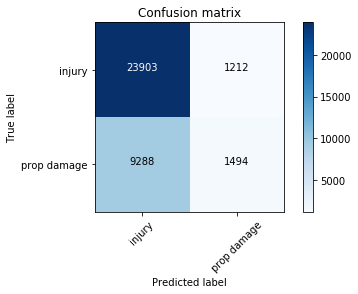

In [43]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat1, labels=[1,2])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['injury','prop damage'],normalize= False,  title='Confusion matrix')

In [44]:
print (classification_report(y_test, yhat1))

              precision    recall  f1-score   support

           1       0.72      0.95      0.82     25115
           2       0.55      0.14      0.22     10782

   micro avg       0.71      0.71      0.71     35897
   macro avg       0.64      0.55      0.52     35897
weighted avg       0.67      0.71      0.64     35897



In [45]:
print (classification_report(y_test, yhat2))

              precision    recall  f1-score   support

           1       0.72      0.95      0.82     25115
           2       0.55      0.14      0.22     10782

   micro avg       0.71      0.71      0.71     35897
   macro avg       0.64      0.55      0.52     35897
weighted avg       0.67      0.71      0.64     35897



In [46]:
print (classification_report(y_test, yhat3))

              precision    recall  f1-score   support

           1       0.72      0.95      0.82     25115
           2       0.55      0.14      0.22     10782

   micro avg       0.71      0.71      0.71     35897
   macro avg       0.64      0.55      0.52     35897
weighted avg       0.67      0.71      0.64     35897



Based on the count of each section, we can calculate precision and recall of each label:

-   **Precision** is a measure of the accuracy provided that a class label has been predicted. It is defined by: precision = TP / (TP + FP)

-   **Recall** is true positive rate. It is defined as: Recall =  TP / (TP + FN)

So, we can calculate precision and recall of each class.

**F1 score:**
Now we are in the position to calculate the F1 scores for each label based on the precision and recall of that label. 

The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It is a good way to show that a classifer has a good value for both recall and precision.

And finally, we can tell the average accuracy for this classifier is the average of the F1-score for both labels, which is 0.64 in this case.


### Log Loss

Now, will try **log loss** for evaluation. In logistic regression, the output can be the probability of injury (or equals to 1). This probability is a value between 0 and 1.
Log loss( Logarithmic loss) measures the performance of a classifier where the predicted output is a probability value between 0 and 1. 

In [47]:
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob1)

0.5776349992894849

In [48]:
log_loss(y_test, yhat_prob2)

0.5776252908717573

In [49]:
log_loss(y_test, yhat_prob3)

0.5776252595502196

## Discussion

As you can see from the above evaluation of the model, i used three different numerical optimizers to find parameters: ‘liblinear’, ‘sag’ and 'lbfgs'. The results show that all three have a same f1-score while a slightly different jaccard similarity and log loss. That means for each y_test data, it is considered as the same category by these three solvers, though with a different probabilities.  <br>
While with a F1-score of 0.64 means this model is not a 'perfect' one, there should be some ways to imporve the accuracy. For example, if i use 80% as training data and 20% as testing, i assume it would have a higher score; and for feature selection and data preprocessing, if i don't combine some similar condition to one group, perhaps the results would be different. But maybe worse? <br>
But one thing is for sure, this data set is not a pretty good one for trainning model since for the labeled data (SEVERITYCODE), it only has 2 categories, which means it's unable to predict whether there could be a more sever collisions like fatality or serious injury, for a sever condition (e.g. weather is raining and road condition is wet, etc.), since the model failed to train for that. 

## Conclusion

For this capstone, I'm using the shared dataset of collisions of Seattle. I selected **WEATHER**, **LIGHTCOND**, **ROADCOND**, **JUNCTIONTYPE**, **PERSONCOUNT** and **VEHCOUNT** as the trainning features and **SEVERITYCODE** as the labeled data. For data preprocessing, I removed the ~5000 rows of missing data and only kept the rows with all data availble; then I converted the string values of some features to numerical ones, by first combing similar conditions to one group, such as wet and snow of road condition. I split 70% of the data to training set and the rest 20% as testing set. For modeling, i used Logistic Regression as the training method, applied three solvers to it and got an F1-score of 0.64, which seems not as good as expected. For improvements, I'll try to use 80% for training and see the results. Or use decision tree instead. But the dataset itself does have drawbacks, since the data is unbalanced and only contains 2 category of labeled data. 